In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2



def translate_patterns(pats):
    
    rpats = []
    for p in pats:
        if re.search('\{([0-9])+\}', p):
            ps = p.split()
            n = re.search('\{([0-9])+\}', p).group(1)
            p = "(" + ps[0] + " *(\w+\s*\W*){0,"+n+"} " + ps[2] + ")|(" + ps[2] + " *(\w+\s*\W*){0,"+n+"} " + ps[0] + ")"
        else:
            p = p.replace(" ","( |-)")
        rpats.append(p)


    rpat = "|".join(rpats)

    #" OR ".join([x.replace('\w*','*').replace('(\w+\s*\W*){','NEAR/').replace('}','') for x in pats])
    opats = [x.replace('\w*','*') for x in pats if '(\w+\s*\W*){' not in x]
    opats = " OR ".join([f'"{x}"' for x in opats])
    npats = [x.replace('\w*','*').replace('(\w+\s*\W*){','NEAR/').replace('}',' ') for x in pats if '(\w+\s*\W*){' in x]
    npats = " OR ".join([f'"{x}"' for x in npats])
    
    if npats:
        wpat = f'TS=({opats}) OR TS=({npats})'
    else:
        wpat = f'TS=({opats})'
    
    return rpat, wpat

def match_docs(rpat, docs, fields):
    mdocs = set([])
    for f in fields:
        tdocs = set(docs.filter(**{f"{f}__iregex": rpat}).values_list('pk',flat=True))
        mdocs = mdocs | tdocs
        
    nmdocs = docs.exclude(id__in=mdocs)
    mdocs = docs.filter(id__in=mdocs)
    return mdocs, nmdocs

def mash_texts(x, pat=None):
    s = ""
    for at in ["de", "kwp","ab", "ti",]:
        if hasattr(x.wosarticle, at) and getattr(x.wosarticle, at):
            t = getattr(x.wosarticle, at)
            if pat:
                t = re.sub(pat, "", t)
            s+=f" {t}"
    return s.strip()


In [2]:
p = Project.objects.get(pk=178)
docs = Doc.objects.filter(query=6956, content__iregex="\w").order_by('id')

## WHY IS OLIVEIRA, 2007 included?
### Also, Nepstad and Stickler, 2008
### Polidoro 2010, very weak - not main conclusion

# Exclude non-climate docs
docs = docs.exclude(pk__in=[
    
    # ENSO
    1461495, # Espinoza 2013
    1626875, # White, 2007
    
    1622783, # Why is Oliveira, 2007 included?
    1627593, # Killeen 2008
    1627701, # Also, Nepstad and Stickler, 2008
    2093363, # Etter
    2090005, # Nepstad, 2006
    1627734, # Polidoro 2010
    
    2089982, # Mars, 2007
    
    2090013, # Randolph 2010
    
    2093360, # Petney 2012
    
    2089960, # Wassenaar, 2007 - LUC
    1627733, # Polidoro 2010, very weak - not main conclusion
    2090004, # Veran 2007 - long line fishing
    2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
    2089944, # Jellyman - eels
    2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
    2089959, # Bruno, 2007 
    1514856, # de Waroux 2012
    2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
    2089950, # Razumov - permafrost and erosion - climate? is the ref there as counter-evidence Nevertheless, the longterm average annual rate
#                             of erosion of the coast line of the bottom of the Arctic
#                             Seas is much lower than in the seas outside the cry
#                             olithozone even under the conditions of the climate’s
#                             warming accompanied by the activation of thermo
#                             abrasion and during the subaqual abrasion processes
#                             (Fig. 5). In particular, this proves the development of
#                             ordinary abrasionaccumulation processes in the Arc
#                             tic Seas, and, here, we cannot say about the influence
#                             of thermal slumps on the formation of the underwater
#                             slope relief
])

#


docs.count()

257

In [3]:
cats = Category.objects.filter(project=p)
cats

<QuerySet [<Category: Mountains, snow and ice>, <Category: Rivers lakes and moisture>, <Category: Terrestrial ES>, <Category: Oceans and Coasts>, <Category: Human and managed>, <Category: not included in table>]>

In [4]:
ldf = pd.DataFrame.from_dict(list(docs.values('id','category__name')))
ldf['v'] = 1
cat_map = ldf.pivot_table(index="id", columns="category__name", values="v").fillna(0).reset_index()
cat_map.head()

category__name,id,Human and managed,"Mountains, snow and ice",Oceans and Coasts,Rivers lakes and moisture,Terrestrial ES
0,1599,0.0,0.0,0.0,0.0,1.0
1,2270,0.0,0.0,1.0,0.0,0.0
2,5570,0.0,0.0,1.0,0.0,0.0
3,11461,0.0,0.0,0.0,1.0,0.0
4,13585,0.0,0.0,0.0,0.0,1.0


In [5]:
all_doc_ids = random.sample(list(Doc.objects.filter(query=7368).values_list('pk',flat=True)),10000)
#all_doc_ids = list(Doc.objects.filter(query=7368).values_list('pk',flat=True))
all_doc_ids = set(all_doc_ids) | set(docs.values_list('pk',flat=True))
all_docs = Doc.objects.filter(pk__in=all_doc_ids,content__iregex="\w")
len(all_doc_ids)

10251

In [6]:
all_doc_df = pd.DataFrame.from_dict(list(all_docs.values("id","title","content")))
print(all_doc_df.shape)
all_doc_df = pd.merge(all_doc_df, cat_map, how="left")
print(all_doc_df.shape)
all_doc_df.head()

cat_labels = [c for c in cats.values_list('name',flat=True) if c in all_doc_df.columns]


(10208, 3)
(10208, 8)


In [7]:
seen_index = all_doc_df[all_doc_df[cat_labels[0]].notna()].index
unseen_index = all_doc_df[all_doc_df[cat_labels[0]].isna()].index
print(seen_index)
print(unseen_index)

Int64Index([   7,    9,   21,   41,   53,   62,   72,   99,  101,  134,
            ...
            8146, 8147, 8148, 8149, 8150, 8151, 8152, 8154, 8155, 8156],
           dtype='int64', length=257)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     8,    10,
               11,
            ...
            10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206,
            10207],
           dtype='int64', length=9951)


In [8]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    max_features=20000,
    tokenizer=snowball_stemmer()
)


#texts = [mash_texts(x) for x in all_docs]
vec.fit(all_doc_df.loc[seen_index,'content'])
X = vec.transform(all_doc_df['content'])
vocab = vec.get_feature_names()

y = np.matrix(all_doc_df[cat_labels])

X

<10208x1918 sparse matrix of type '<class 'numpy.float64'>'
	with 1040592 stored elements in Compressed Sparse Row format>

In [9]:
colsum = np.array(X[seen_index].sum(axis=0))[0]
print(len(colsum))
nzs = np.argwhere(colsum>0)
print(len(nzs))
X_s = X[:,nzs[:,0]]
X_s

1918
1918


<10208x1918 sparse matrix of type '<class 'numpy.float64'>'
	with 1040592 stored elements in Compressed Sparse Row format>

In [10]:
nzs[:,0]

array([   0,    1,    2, ..., 1915, 1916, 1917])

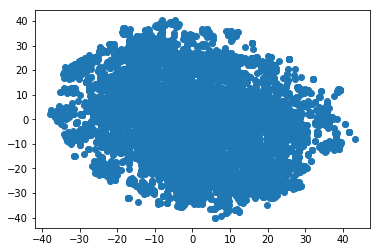

In [11]:
tsne = mTSNE(n_components=2, verbose=0, n_jobs=4)
tsne_results = tsne.fit_transform(X.toarray())


plt.scatter(tsne_results[:,0],tsne_results[:,1])

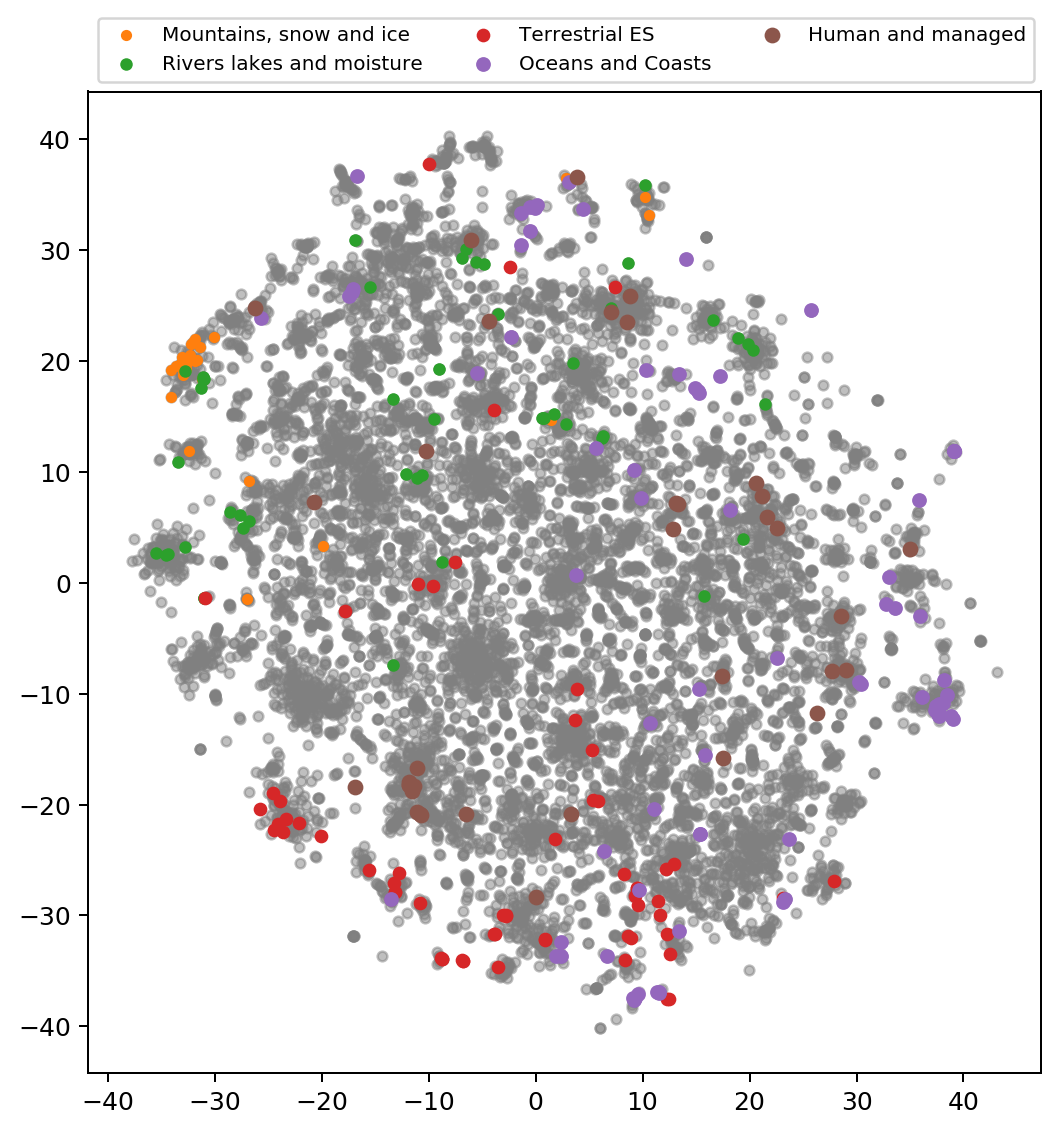

In [12]:
#cat_labels = [c for c in cats.values_list('name',flat=True) if c in doc_df.columns]

fig, ax = plt.subplots(figsize=(6,6), dpi=180)

s = 15
ax.scatter(
    tsne_results[:,0], tsne_results[:,1],
    s=s, c="grey", alpha=0.5
)

for i,c in enumerate(cat_labels):
    ids = all_doc_df[all_doc_df[c]==1].index
    s+=5
    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        c=f"C{i+1}",
        lw=0,
        #c="None",
        s=s,
        label=c
    )
    
ax.legend(loc="lower left", bbox_to_anchor=(0,1), fontsize=8, ncol=3)

fig.tight_layout()

plt.savefig("../plots/unseen_cats.png", bbox_inches="tight")

In [13]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))

clf.fit(X[seen_index],y[seen_index,:])
y_pred = clf.predict(X[unseen_index])

predictions_df = pd.DataFrame(y_pred)
predictions_df.index = unseen_index
predictions_df.columns = cat_labels
predictions_df.head()



,"Mountains, snow and ice",Rivers lakes and moisture,Terrestrial ES,Oceans and Coasts,Human and managed
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


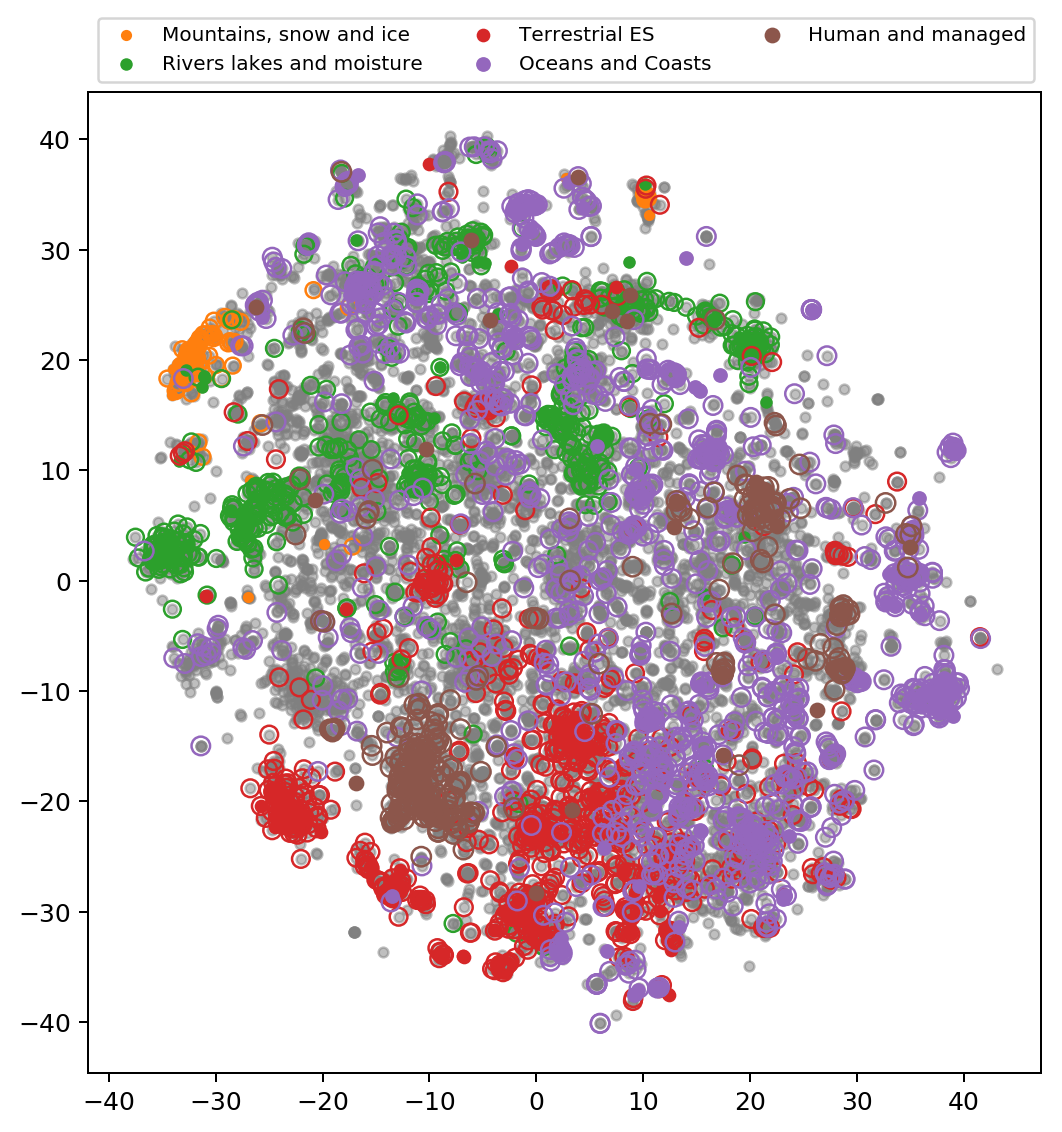

In [14]:
#cat_labels = [c for c in cats.values_list('name',flat=True) if c in doc_df.columns]

fig, ax = plt.subplots(figsize=(6,6), dpi=180)

s = 15
ax.scatter(
    tsne_results[:,0], tsne_results[:,1],
    s=s, c="grey", alpha=0.5
)

for i,c in enumerate(cat_labels):
    ids = all_doc_df[all_doc_df[c]==1].index
    s+=5
    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        c=f"C{i+1}",
        lw=0,
        #c="None",
        s=s,
        label=c
    )
    
    ids = predictions_df[predictions_df[c]==1].index

    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        edgecolors=f"C{i+1}",
        lw=1,
        c="None",
        s=s+20,
    )
    
ax.legend(loc="lower left", bbox_to_anchor=(0,1), fontsize=8, ncol=3)

fig.tight_layout()

plt.savefig("../plots/predicted_unseen_cats.png", bbox_inches="tight")

In [15]:
y_pred_prob = clf.predict_proba(X[unseen_index])

predictions_prob_df = pd.DataFrame(y_pred_prob)
predictions_prob_df.index = unseen_index
predictions_prob_df.columns = cat_labels
predictions_prob_df.head()

,"Mountains, snow and ice",Rivers lakes and moisture,Terrestrial ES,Oceans and Coasts,Human and managed
0,0.011150,0.162508,0.031720,0.731921,0.053529
1,0.029822,0.189621,0.164979,0.044455,0.149535
2,0.055211,0.475608,0.047161,0.077508,0.029099
3,0.024919,0.110689,0.015897,0.110299,0.533476
4,0.018552,0.049617,0.017573,0.005702,0.999995


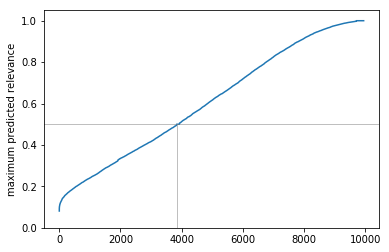

In [16]:
predictions_prob_df["m"] = predictions_prob_df.max(axis=1)
pdf = predictions_prob_df.sort_values('m').reset_index(drop=True)
plt.plot(pdf['m'])

plt.axhline(0.5, lw=0.5, c="grey")

cutoff = predictions_prob_df[predictions_prob_df['m']<0.5].shape[0] + 1
plt.plot([cutoff]*2,[0,0.5], lw=0.5, c="grey")

plt.ylabel("maximum predicted relevance")

plt.ylim(ymin=0)

plt.savefig('../plots/maximum_predicted_relevance.png')

In [17]:
from mordecai import Geoparser
geo = Geoparser()

geo.geoparse("I travelled from Oxford Circus to London Bridge, via Bank")

Using TensorFlow backend.
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ma





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[{'country_conf': 0.611725,
  'country_predicted': 'GBR',
  'geo': {'admin1': 'England',
   'country_code3': 'GBR',
   'feature_class': 'S',
   'feature_code': 'BDG',
   'geonameid': '6619889',
   'lat': '51.50821',
   'lon': '-0.08763',
   'place_name': 'London Bridge'},
  'spans': [{'end': 47, 'start': 34}],
  'word': 'London Bridge'}]

NameError: name 'row' is not defined

In [ ]:
places = []

ccs = []

for i, row in all_doc_df.loc[unseen_index,:].iterrows():
    continent = "None"
    cat = None
    for c in cat_labels:
        if predictions_df.loc[i,c]==1:
            cat = c
    gp = geo.geoparse(row["content"])
    for p in gp:
        p["cat"] = cat
        if "geo" in p:
            try:
                a2 = country_alpha3_to_country_alpha2(p["geo"]["country_code3"])
                continent = country_alpha2_to_continent_code(a2)
            except:
                pass
        places.append(p)
        
    ccs.append({
        "continent": continent,
        "category": cat
    })   

In [ ]:
cc_df = pd.DataFrame.from_dict(ccs)
cc_df.head()

In [ ]:
cc_counts = cc_df.groupby(['category','continent']).size().reset_index()
cc_counts = cc_counts.pivot(index="category",columns="continent",values=0)

import seaborn as sns
sns.heatmap(
    cc_counts,
    cmap="Blues",
    linecolor="#F0F0F0",
    linewidths=1
)
fig.tight_layout()

plt.savefig("../plots/predicted_category_continent.png", bbox_inches="tight")

In [ ]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6), dpi=180)

ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines(lw=0.25)
ax.stock_img(alpha=0.3)
#ax.borders(lw=0.25)



for c in cat_labels:
    try:
        lat, lon, pl = zip(
            *[(
                p["geo"]["lat"], 
                p["geo"]["lon"], 
                p["word"],
            ) for p in places if "geo" in p and p["cat"]==c]
        )
    except:
        continue

    ax.plot(
        lon, lat,
        ".",
        #s=25,
        markersize=4,
        markeredgecolor="black",
        markeredgewidth=0.1,
        alpha=0.3,
        transform=ccrs.PlateCarree(),
        label=c
    )
    

ax.set_global()

ax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5,0))

ax.set_title(f"Climate impact attribution research: {len(places)} place mentions in {len(unseen_index)} documents")

fig.tight_layout()

plt.savefig("../plots/predicted_map.png", bbox_inches="tight")

plt.show()